<a href="https://colab.research.google.com/github/vicmancr/CardiacSegmentation_BDAS/blob/main/Part_02-Model_building_and_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this Notebook, we will build a simple deep learning model (called U-Net) and use the data that we have prepared prepared in the first part to train it.

# Build your model

In this section we will design the model architecture that will be used for the segmentation task (for predicting the segmentations that we saw in the `Dataset` notebook).

We start by building the simple and successful U-Net model by [Ronneberger, Fisher and Brox (2015)](https://doi.org/10.1007/978-3-319-24574-4_28):

<img src="https://drive.google.com/uc?id=1Kuu5hPwxV2lUAgq_cXG0rDwTKFiJYPjF" alt="UNet architecture from Ronneberger, Figher and Brox paper." width="700"/>

This code is based on https://github.com/milesial/Pytorch-UNet.

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [66]:
PATH_TO_DATA = '../data'

### Model structure

In pytorch, the models have the following `class` structure, with a initialization or constructor function and a `forward` function that is executed everytime the model is called:

In [67]:
class UNetSample(nn.Module):
    def __init__(self):
        'Define the LAYERS of network'
        super().__init__()
        self.layer1 = nn.Identity()
        self.layer2 = nn.Identity()
        
        self.outlayer = nn.Identity()

    def forward(self, input_image):
        'Specify how data is TRANSFORMED through the network'
        x1 = self.layer1(input_image)
        x2 = self.layer2(x1)
        logits = self.outlayer(x2)

        return logits

We work with these models by instantiating them first

In [68]:
model = UNetSample()

and calling them on input data (images). An image is passed as input and transformed to a new image (identity transformation for this case) by calling the `forward` function:

In [69]:
image = torch.ones((5,5))
model(image)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

### Let's build a real U-Net

We need the building blocks first. So let's build them in a clean and modular way.

First, we need the **basic building block**, which is a composition of a convolutional operation, a normalization layer and an activation function (x2):

<img src='https://drive.google.com/uc?id=1nzV0ympWvF-V3ExEDvgL8q1ksW_AK5oO' alt="Basic convolutional blocks" width="500"/>

Notice the use of dynamical variables for the `output_channels` to implement blocks with varying number of channels (64, 128, 256, 512).

In [70]:
class DoubleConv(nn.Module):
    '''
    |------|    |------|    |------|    |------|    |------|    |------|
    | Conv | => | [BN] | => | ReLU | => | Conv | => | [BN] | => | ReLU |
    |------|    |------|    |------|    |------|    |------|    |------|
    '''
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            # One
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            # Two
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

And then we can compose it with the **downsampling block**

<img src='https://drive.google.com/uc?id=12GkrIhoAXLACUi8wKWPVkjVpviuGeGbk' alt='Downsampling block' width='150'/>


In [71]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            # Use the previous block
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

and the **upsampling block**

<img src='https://drive.google.com/uc?id=1rwO-LHo5XJsH9KWEWvGX2VRXx04xoubv' alt='Upsampling block' width='150'/>

In [72]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # Notice the two inputs:
        # - x1 (the data from the previous block, goes through the green arrow)
        # - x2 (the data from the equivalent layer of the encoding path, goes through the gray arrow)
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # Fix size issues to match dimensions of x1 and x2 arrays
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # Concatenate both arrays
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

The **last layer** is simply a 1x1 convolution (light blue color in the figure above) so we create another class for it as well:

In [73]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

Now we can put the pieces together to create **our first model**

In [74]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Encoding leg
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        # Decoding leg
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [75]:
model = UNet(1,3)

In [76]:
image = torch.ones((1,1,256,256))
output = model(image)
output.shape

torch.Size([1, 3, 256, 256])

In [77]:
import matplotlib.pyplot as plt

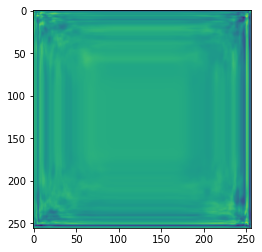

In [78]:
plt.imshow(output[0,0].detach().numpy())

---
# Parenthesis: example of convolutional filter

The network we have defined has a bunch of parameters that define the **filters** of the convolutional operations. These filters are learnt through training. However, there are some pre-defined filters that are interpretable and that motivate this design.

Let's see the filter used for detecting **edges**:

In [79]:
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Take one example image

In [80]:
image = cv2.imread(f'{PATH_TO_DATA}/mnms_png/training/A0S9V9/A0S9V9_sa_ED_z05.png')[...,0]

And let's defined a convolutional operation with a filter defined _a priori_ by us: the edge detector. Note that it's simply the matrix
$$
\left(
\begin{array}{ccc}
1 & 1 & 1 \\
0 & 0 & 0 \\
-1 & -1 & -1 
\end{array}
\right)
$$
(for horizontal edges).

In [81]:
resized_image4D = np.reshape(image, (1, 1, image.shape[0], image.shape[1]))
t = torch.from_numpy(resized_image4D/255.).float()

conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, bias=False)
#conv.weight = nn.Parameter((torch.Tensor([[-1,0,1],[-1,0,1],[-1,0,1]])/9.0).reshape(1,1,3,3))
conv.weight = nn.Parameter((torch.Tensor([[1,1,1],[0,0,0],[-1,-1,-1]])/9.0).reshape(1,1,3,3))

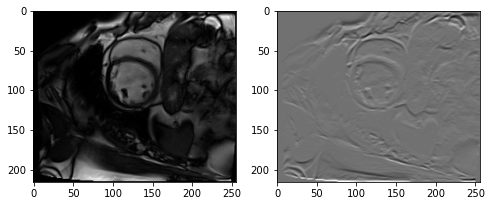

In [84]:
fig,axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(t[0,0].detach(), cmap='gray')
axs[1].imshow(conv(t)[0,0].detach(), cmap='gray')
plt.show()

The interpratation is the following: every time there is a big difference between neighboring pixels, multiplying by the filter will give a big value (positive if the pixels on top are brighter and negative if the pixels on top are darker -> check this in the image). On the contrary, if the pixels are homogeneous in the image, when we multiply by the filter matrix, the result will be close to zero (as you can observe in gray color all around homogeneous regions).

**Exercise:** change the filter to highlight vertical edges.

**End of parenthesis.** Let's make our model learn these filters automatically.

# Train your model

Now we are ready to train a deep learning model. For the training we need to consider the selection of adequate **data augmentation**, one or a combination of several **loss functions** and an **optimizer**.

In [20]:
import glob
import torch
from skimage.transform import resize 
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

## Loss function

The function that the network is minimizing. It must be related to the objective and lower values mean better performance.

One very commonly used loss is the **Cross-Entropy (CE) loss**:
\begin{equation}
    CE(p,q) = - \sum_{x\in\mathcal{X}} p(x) \log q(x)
\end{equation}
for $p$ and $q$ probability distributions with support $\mathcal{X}$.

### What is the translation to the discrete network outputs?

\begin{equation}
    \ell_{CE}(y,\hat{y}) = - \sum_{i=1}^{\text{output size}} y_i \log\left(\hat{y}_i\right)
\end{equation}
where $y$ is the groundtruth vector (as one-hot encoding) and $\hat{y}$ represents the prediction probabilities. 

This sum is greater than zero if the positives ($y_j=1$) have probabilities below 1 ($\hat{y}_j < 1 \Rightarrow \log(\hat{y}_j) < 0$). The sum reaches its minimum (zero) when all positives have a prediction probability of 1.

[You can convince yourself by carefully analyzing the expression for $\ell_{CE}$ and by checking the implementation in [pytorch](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).]

The CE loss only focuses on the positives, but its variant, the **Binary Cross-Entropy** also considers the negatives in the sum:
\begin{equation}
    \ell_{BCE}(y,\hat{y}) = - \sum_{i=1}^{\text{output size}} \left( y_i \log\left(\hat{y}_i\right) + (1-y_i) \log\left(1-\hat{y}_i\right) \right)
\end{equation}

Other losses can be considered. See the recent publication by [Du et al. 2022](https://doi.org/10.1109/JBHI.2022.3222390) where the authors present a nice comparison between losses for medical image segmentation, in case you are interested in knowing more. Or this work by [Ma et al. 2021](https://www.sciencedirect.com/science/article/pii/S1361841521000815):

<img src="https://drive.google.com/uc?id=1zajXDhESbTzCfcuOsHwoC9Be6DwRY28D" alt="Classification of loss functions used in image segmentation" width="600"/>

[Source: https://github.com/JunMa11/SegLoss]

For this run we'll use the **Binary Cross-Entropy**, but you can experiment with other losses and combinations of them.

In [17]:
loss_fn = nn.BCEWithLogitsLoss()

### Optimizers

The algorithm that updates the weights of the network based on the loss function.

There are plenty of algorithms and variations, but we will use the basic one: **Stochastic Gradient Descent (SGD)**.

In [19]:
model = UNet(n_channels=1, n_classes=4)
# We need to provide the weights of the model we are training
optimizer = optim.SGD(model.parameters(), lr=1e-3)

### Data augmentation

The variations introduced to the training data to increase its diversity in position, location, appearance, etc. This step has shown to be key for generalization, even to images that were acquired with machines from different manufacturers ([Campello et al. 2021](https://doi.org/10.1109/TMI.2021.3090082)).

Some examples of the variations performed to images:

<img src="https://drive.google.com/uc?id=1Rs0kGw9vPCAg8rZqNj-Jy01wSEddm4wd" alt="Example of images obtained after the application of different shape and intensity transformations" width="600"/>

[Source: Campello et al. 2021]

To implement the different data augmentation we'll use [`monai`](https://monai.io/), a python-based framework for deep learning in healthcare imaging.

It has many functions that will save us time.

In [ ]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.6 MB/s eta 0:00:00


In [21]:
from monai.data import Dataset
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Resized, RandRotated, \
    ScaleIntensityd, EnsureTyped, RandBiasFieldd, RandAdjustContrastd, \
    AsDiscreted, ToTensord, Rand2DElasticd

In monai, we specify the augmentation techniques as a list of transformations. We'll consider some of the augmentations listed above: bias field modification, contrast adjustment, elastic deformations and rotations.

In [22]:
k = ["img", "seg"]
num_classes = 4
spatial_size = (256, 256)

seg_transforms = [
    LoadImaged(keys=k),
    EnsureChannelFirstd(keys=k),
    ScaleIntensityd(keys=["img"]),
    RandBiasFieldd(keys=["img"], prob=0.5),
    RandAdjustContrastd(keys=["img"], prob=0.5),
    Rand2DElasticd(
        keys=k, prob=1, spacing=[20,20],
        magnitude_range=(1,2), mode=["bilinear", "nearest"]),
    ToTensord(keys=k),
    # Round mask values to closest integer
    AsDiscreted(keys=["seg"], rounding='torchrounding'),
    # Convert mask labels to num_classes image with 1s
    AsDiscreted(
        keys=["seg"], to_onehot=num_classes
    ),
    RandRotated(
        keys=k, prob=0.5, range_x=15,
        mode=['bilinear', 'nearest']
    ),
    Resized(keys=k, spatial_size=spatial_size),
    EnsureTyped(keys=k),
]

In [23]:
image_filenames = list(sorted(glob.iglob(f'{PATH_TO_DATA}/mnms_png/training/*/*_sa_E?_z??.png')))
mask_filenames  = list(sorted(glob.iglob(f'{PATH_TO_DATA}/mnms_png/training/*/*_sa_E?_z??_gt.png')))

transform = Compose(seg_transforms)
train_files_dict = [{"img": img, "seg": seg} for img, seg in zip(image_filenames, mask_filenames)]

train_dset = Dataset(train_files_dict, transform=transform)
train_dloader = DataLoader(train_dset, batch_size=4, shuffle=True)

In [24]:
def train(dataloader, model, loss_fn, optimizer, device='cuda'):
    size = len(dataloader.dataset)
    model.train()
    for bidx, batch in enumerate(dataloader):
        X, y = batch['img'], batch['seg']
        X, y = X.to(device).float(), y.to(device).float()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if bidx % 100 == 0:
            loss, current = loss.item(), bidx * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

model = UNet(1, num_classes).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dloader, model, loss_fn, optimizer, device)
print("Done!")

Note that with a batch size of 4 we get loss information every 100 iterations with batches of 4 images = 400 images already gone through the model.

Once the training is finished, we can save the model to disk, so that we can recover it whenever we want.

In [ ]:
import os
os.makedirs('./models', exist_ok=True)
torch.save(model.state_dict(), './models/model_1ep_bcewlogits_sgd.pt')

Finally, we can check the predictions of the model on the testing (unseen) images.

In [ ]:
test_transforms = [
    LoadImaged(keys=k),
    EnsureChannelFirstd(keys=k),
    ScaleIntensityd(keys=["img"]),
    ToTensord(keys=k),
    # Round mask values to closest integer
    AsDiscreted(keys=["seg"], rounding='torchrounding'),
    # Convert mask labels to num_classes image with 1s
    AsDiscreted(
        keys=["seg"], to_onehot=num_classes
    ),
    Resized(keys=k, spatial_size=spatial_size),
    EnsureTyped(keys=k),
]

In [ ]:
image_filenames = list(sorted(glob.iglob(f'{PATH_TO_DATA}/mnms_png/testing/*/*_sa_E?_z??.png')))
mask_filenames  = list(sorted(glob.iglob(f'{PATH_TO_DATA}/mnms_png/testing/*/*_sa_E?_z??_gt.png')))

transform = Compose(test_transforms)
test_files_dict = [{"img": img, "seg": seg} for img, seg in zip(image_filenames, mask_filenames)]

test_dset = Dataset(test_files_dict, transform=transform)
test_dloader = DataLoader(test_dset, batch_size=1, shuffle=False)

In [ ]:
batch = train_dset.__getitem__(3)
img, gt = batch['img'], batch['seg']
model.eval()
pred = model(img.to(device).unsqueeze(0))
plt.imshow(img[0].detach(), cmap='gray'); plt.show()
out = F.softmax(pred, dim=1).argmax(dim=1).squeeze()
plt.imshow(out.detach().cpu(), cmap='gray'); plt.show()
gt.shape
gt = gt.argmax(dim=0)
plt.imshow((gt-gt.min())/(gt.max()-gt.min()), cmap='gray'); plt.show()


As you can see, the prediction is all black (all predicted as background). This is because the model is underfitted, that is it needs to train for a longer time.

SGD needs more time for the model to learn meaningfull patterns of the image and make good predictions.

Additionally, SGD takes more time compared to need optimization algorithms. Using a more efficient algorithm will help saving training time. Adam is a better algorithm that is in general better for finding good parameters for our model.

Let's try it.

In [ ]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

model = UNet(1, num_classes).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dloader, model, loss_fn, optimizer, device)
print("Done!")

And let's save the model again.

In [ ]:
torch.save(model.state_dict(), './models/model_1ep_bcewlogits_adam.pt')

Note that the loss values (a sort of prediction error), was close to 5 times lower already by the first 100 iterations. This means that Adam was able to adjust the parameters of the model so that the error is lower much faster than SGD.

Despite the faster decrease in error, you can check that the predictions are still bad and we need to train the model for more epochs. Try running it for **10 or 20 epochs** and check the results.

Q: Why are we using **binary** cross entropy if we have 4 classes?

We have 4 classes but these are split in 4 different channels. Each of these channels represents a **binary** segmentation task. Let's see how the segmentation looks like when we prepare it for training:

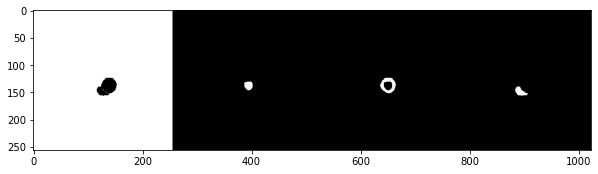

In [35]:
batch = train_dset.__getitem__(5)
plt.figure(figsize=(10,4))
plt.imshow(np.hstack([*batch['seg']]), cmap='gray')
plt.show()

You can clearly see what corresponds to background, label 1 (left ventricle), label 2 (myocardium) and label 3 (right ventricle).

---
# Logging losses in training and validation

So far we have been training and printing results in a very unordered way. Now we will build a structured pipeline that will automatically save the best model on the validation set (the hold-out set), plot the loss function evolution and some qualitative results for the predictions.

In [25]:
import os
from tqdm import tqdm
os.makedirs('./logs', exist_ok=True)
os.makedirs('./plots', exist_ok=True)

def train_improved(dataloader, model, model_name, loss_fn, optimizer, device, epochs):
    # Example of train loop implementation
    losses_train_epochs = []
    losses_val_epochs = []
    accs_epochs = []
    acc_max = 0 
    loss_min = 100

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        model.train()
        losses_train = []

        for batch in tqdm(dataloader['train'], ascii=True):
            img, gt = batch['img'], batch['seg']
            img, gt = img.to(device).float(), gt.to(device).float()
            optimizer.zero_grad()
            output = model(img)
            loss = loss_fn(output, gt)
            losses_train.append(loss.item())
            loss.backward()
            optimizer.step()

        losses_train_epochs.append(np.mean(losses_train))
        model.eval()
        losses_val = []
        accs = []
        for bidx, batch in tqdm(enumerate(dataloader['val']), ascii=True):
            img, gt = batch['img'], batch['seg']
            img, gt = img.to(device).float(), gt.to(device).float()
            pred = model(img)
            loss = loss_fn(pred, gt)
            losses_val.append(loss.item())
            acc = dice_coef(gt, F.softmax(pred, dim=1))
            accs.append(np.mean(acc.detach().cpu().numpy(), axis=1))

            if bidx % 100 == 0:
                out = F.softmax(pred, dim=1)
                aux = np.hstack((
                    out[0].argmax(dim=0).cpu().detach()/4,
                    img[0,0].cpu().detach(),
                    gt[0].argmax(dim=0).cpu().detach()/4
                ))
                plt.imshow(aux, cmap='gray'); plt.savefig('./plots/sample_ep{:02d}_bidx{:03d}.png'.format(epoch, bidx))

        acc_mean = np.mean(accs)
        loss_mean = np.mean(losses_val)

        if acc_max <= acc_mean and loss_min >= loss_mean: 
            acc_max = acc_mean
            loss_min = loss_mean
            torch.save(
                {'model_state_dict': model.state_dict()},
                f'models/{model_name}.pth')

        accs_epochs.append(accs)
        losses_val_epochs.append(losses_val)
        print('Epoch: {}. Train Loss: {:.5f}. Val Loss: {:.5f}. Val Accuracy: {:.5f}.'.format(
            epoch, np.mean(losses_train), np.mean(losses_val), np.mean(accs)))

    np.save(f'logs/{model_name}_val_loss.npy', np.array(losses_val_epochs))
    np.save(f'logs/{model_name}_train_loss.npy', np.array(losses_train_epochs))

Note: we will also use the Dice coefficient to assess the accuracy of our predictions. See [Wikipedia](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) for more info about it.

In [36]:
def dice_coef(y_true, y_pred):
    if len(y_true.shape) == 3:
        y_true = y_true.unsqueeze(0)
    if len(y_pred.shape) == 3:
        y_pred = y_pred.unsqueeze(0)
    
    b, ch, *_ = y_true.shape
    smooth = 0.00001
    intersection = torch.sum(y_true.view(b,ch,-1) * y_pred.view(b,ch,-1), dim=2) + smooth
    union = torch.sum(y_true, dim=[2,3]) + torch.sum(y_pred, dim=[2,3]) + smooth

    return 2 * intersection / union

Prepare the dataset that will be used for training and the transformations that we will apply during training:

In [37]:
k = ["img", "seg"]
num_classes = 4
spatial_size = (256, 256)

seg_transforms = [
    LoadImaged(keys=k),
    EnsureChannelFirstd(keys=k),
    ScaleIntensityd(keys=["img"]),
    ToTensord(keys=k),
    # Round mask values to closest integer
    AsDiscreted(keys=["seg"], rounding='torchrounding'),
    # Convert mask labels to num_classes image with 1s
    AsDiscreted(
        keys=["seg"], to_onehot=num_classes
    ),
    Resized(keys=['img'], spatial_size=spatial_size),
    Resized(keys=['seg'], spatial_size=spatial_size, mode='nearest'),
    EnsureTyped(keys=k),
]

In [38]:
import pandas as pd
info = pd.read_csv(f'{PATH_TO_DATA}/mnms_info.csv')

In [39]:
import numpy as np
batch_size = 4

image_filenames = np.array(sorted(glob.iglob(f'{PATH_TO_DATA}/mnms_png/training/*/*_sa_E?_z??.png')))
mask_filenames  = np.array(sorted(glob.iglob(f'{PATH_TO_DATA}/mnms_png/training/*/*_sa_E?_z??_gt.png')))

# We are filtering by images belonging to Centre 2 (you can comment these lines to use all images)
centre_ids = info[info.Centre == 2]['External code'].values#[:50]
image_filenames = np.array([f for f in image_filenames if f.split('/')[-2] in centre_ids])
mask_filenames = np.array([f for f in mask_filenames if f.split('/')[-2] in centre_ids])

split_fraction = 0.8
num = int(len(image_filenames) * split_fraction)
_order = np.arange(len(image_filenames))
np.random.shuffle(_order)

transform = Compose(seg_transforms)
train_files_dict = [{"img": img, "seg": seg} for img, seg in zip(image_filenames[_order[:num]], mask_filenames[_order[:num]])]
val_files_dict = [{"img": img, "seg": seg} for img, seg in zip(image_filenames[_order[num:]], mask_filenames[_order[num:]])]

print('Length data', len(train_files_dict), len(val_files_dict))
train_dset = Dataset(train_files_dict, transform=transform)
val_dset = Dataset(val_files_dict, transform=transform)
train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
val_dloader = DataLoader(val_dset, batch_size=1, shuffle=False)

dataloader = {'train': train_dloader, 'val': val_dloader}


Length data 788 198


We train the model like this:

Epoch 1
-------------------------------


100%|#########################################| 197/197 [01:51<00:00,  1.76it/s]
198it [00:13, 14.29it/s]


Epoch: 0. Train Loss: 0.15981. Val Loss: 0.04242. Val Accuracy: 0.36741.


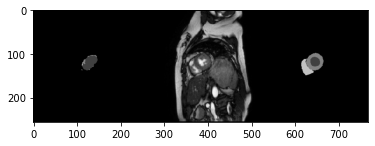

In [40]:
device = 'cuda'
model = UNet(n_channels=1, n_classes=num_classes)
model.to(device)
# We need to provide the weights of the model we are training
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
# CHANGE TO 10 (or more)
epochs = 1

train_improved(dataloader, model, f'model_centre2_{epochs}ep_adam', loss_fn, optimizer, device, epochs)

Go and check now that you got images saved in the **plots** folder and also the loss function values saved at **logs** in _.npy_ files (you can load them as _np.load(file_path)_). Exercise: plot the loss function values with matplotlib.

# Testing

When the model is finished training, we can test its performance by computing the accuracy agains an **unseen** dataset (test dataset). I'll let you compile the accuracy for all cases and extract mean and standard deviation.

Let's simply show here how the predictions look like. Let's load the test set:

In [41]:
image_filenames = list(sorted(glob.iglob(f'{PATH_TO_DATA}/mnms_png/testing/*/*_sa_E?_z??.png')))
mask_filenames  = list(sorted(glob.iglob(f'{PATH_TO_DATA}/mnms_png/testing/*/*_sa_E?_z??_gt.png')))

transform = Compose(seg_transforms)
test_files_dict = [{"img": img, "seg": seg} for img, seg in zip(image_filenames, mask_filenames)]

test_dset = Dataset(test_files_dict, transform=transform)
test_dloader = DataLoader(test_dset, batch_size=1, shuffle=False)

In [46]:
batch = test_dset.__getitem__(0)
device = 'cuda'
model.to(device)
model.eval()
pred = model(batch['img'][0].T.unsqueeze(0).float().to(device).unsqueeze(0))

We can compute the Dice accuracy for each class:

In [47]:
out = F.softmax(pred, dim=1)
dice_coef(batch['seg'].to(device), out)

tensor([[9.9896e-01, 5.1626e-07, 5.2530e-07, 3.3873e-07]], device='cuda:0',
       grad_fn=<AliasBackward0>)

And visualize the results:

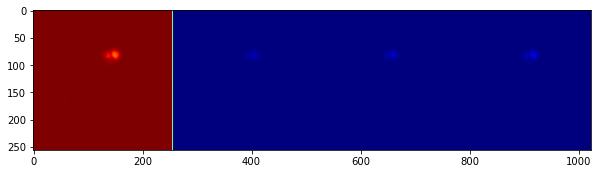

In [48]:
plt.figure(figsize=(10,4))
plt.imshow(np.hstack([*out[0].cpu().detach()]), cmap='jet')

The results will get better if your model is trained for more epochs. **Exercise:** run these lines after training a model for 10 or more epochs.

Note: you can also change the argument _cmap_ to 'gray' to visualize it in grayscale.

---
**Exercise:** train four models with data from the four different centers and compare their accuracy on the test set seggregated per center.

## Loading pre-trained models

When we have a model save to disk, as in the fuction **train_improved**, we can later load the model with the following code. Just make sure that you send the model to the gpu or device where your data is (with `model.to('cuda')` or `model.to(device)`)

In [ ]:
model = UNet(1, 4)
model.load_state_dict(torch.load('models/<name_of_your_model>.pth')['model_state_dict'])
model.eval()

Give it a try with your own model!

Note: the model weights need to match the architecture defined in your class **UNet**. In other words, if you don't know how the weights need to be operated, you cannot load them.

---
# Bonus: Activations

You can have a look at the different layers of the network to see what is going on (spoiler: is not very interpretable). Let me show you:

We need an auxiliary function to extract the activations from the model and we need to attach it whenever we are focusing. This is called a _hook_, since we are fishing in the model for this layers.

In [50]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output[0].detach()
    return hook

In [51]:
model.down1.maxpool_conv[1].double_conv.register_forward_hook(get_activation('down1'))
model.down2.maxpool_conv[1].double_conv.register_forward_hook(get_activation('down2'))
model.down3.maxpool_conv[1].double_conv.register_forward_hook(get_activation('down3'))
model.down4.maxpool_conv[1].double_conv.register_forward_hook(get_activation('down4'))
model.up1.conv.double_conv.register_forward_hook(get_activation('up1'))
model.up2.conv.double_conv.register_forward_hook(get_activation('up2'))
model.up3.conv.double_conv.register_forward_hook(get_activation('up3'))
model.up4.conv.double_conv.register_forward_hook(get_activation('up4'))

Now, every time we run the model, the dict _activation_ will store the outputs of the layers we defined in the previous cell. Let's see that:

In [54]:
batch = test_dset.__getitem__(5)
img = batch['img'].unsqueeze(0).to(device)
_ = model(img)

You can check now that _activation_ is full with arrays. Let's plot some of them:

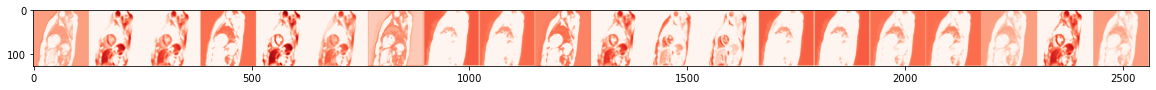

In [60]:
# First downsampling layer (first steps in the encoder leg on the left)
plt.figure(figsize=(20,4))
plt.imshow(np.hstack([*activation['down1'].cpu().detach().numpy()[:20]]), cmap='Reds')
plt.show()

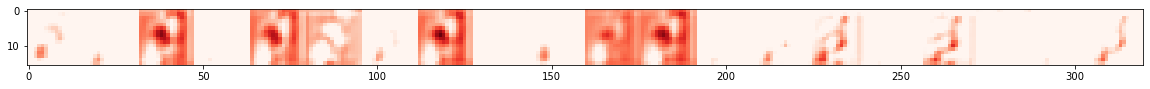

In [61]:
# Same, but for the fourth layer. Notice the decrease in spatial resolution. The images get smaller and smaller.
plt.figure(figsize=(20,4))
plt.imshow(np.hstack([*activation['down4'].cpu().detach().numpy()[:20]]), cmap='Reds')
plt.show()

Note: **we are only plotting the first 20 channels** (look at the [:20] in the plot). There are 32,64,128,256 and so on channels, as we decrease in the encoding path.

And we can do the same for the decoding path:

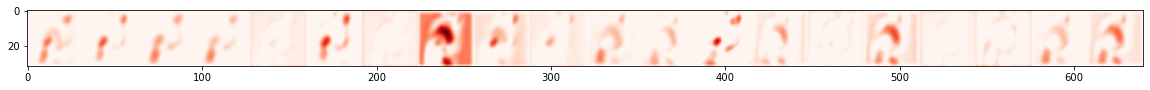

In [63]:
plt.figure(figsize=(20,4))
plt.imshow(np.hstack([*activation['up1'].cpu().detach().numpy()[:20]]), cmap='Reds')
plt.show()

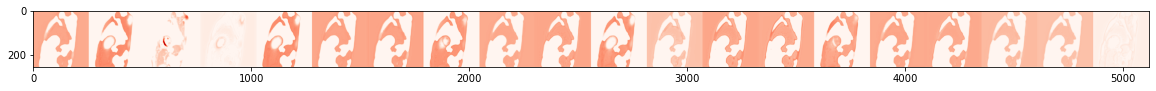

In [64]:
plt.figure(figsize=(20,4))
plt.imshow(np.hstack([*activation['up4'].cpu().detach().numpy()[:20]]), cmap='Reds')
plt.show()